In [8]:
from datasets import Dataset, ClassLabel
import pandas as pd
import re
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
import torch.nn as nn
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

#1. Načtení CSV datasetu 
df2 = pd.read_csv("empathetic_dialogues.csv")
df2['text'] = df2['Situation'].fillna('') + " " + df2['empathetic_dialogues'].fillna('')

# Mapování emocí na integer labely
emotion2label = {
    # Negative emotions
    "sad": 0, "angry": 0, "afraid": 0, "anxious": 0, "ashamed": 0, "disgusted": 0,
    "embarrassed": 0, "guilty": 0, "jealous": 0, "lonely": 0, "disappointed": 0,
    "terrified": 0, "nostalgic": 0, "devastated": 0, "annoyed": 0,
    
    # Neutral emotions
    "neutral": 1, "surprised": 1, "confused": 1, "anticipating": 1, "apprehensive": 1,
    "hopeful": 1, "caring": 1, "sentimental": 1,
    
    # Positive emotions
    "happy": 2, "excited": 2, "content": 2, "grateful": 2, "proud": 2, "impressed": 2,
    "joyful": 2, "trusting": 2, "prepared": 2, "confident": 2
}

df2['label'] = df2['emotion'].map(emotion2label).fillna(1).astype(int)

ds2 = Dataset.from_pandas(df2[['text','label']])

# 2. Maskování citlivých údajů 
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str): return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

ds2_clean = ds2.map(lambda x: {'text': mask_sensitive(x['text']), 'label': x['label']})
ds2_clean = ds2_clean.filter(lambda x: len(x['text'])>5)

# 3. Tokenizace 
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Převod labelu na ClassLabel
new_features = ds2_clean.features.copy()
new_features['label'] = ClassLabel(names=["Negative","Neutral","Positive"])
ds2_clean = ds2_clean.cast(new_features)
tokenized_ds2 = ds2_clean.map(tokenize, batched=True)

# 4. Rozdělení datasetu 
split_ds2 = tokenized_ds2.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds2 = split_ds2['train']
testval_ds2 = split_ds2['test'].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds2 = testval_ds2['train']
test_ds2 = testval_ds2['test']

print(f"Train2: {len(train_ds2)}, Validation2: {len(valid_ds2)}, Test2: {len(test_ds2)}")

# 5. Výpočet vah tříd s kontrolou chybějících tříd 
def compute_class_weights(dataset, num_labels=3):
    counter = Counter(dataset['label'])
    total = sum(counter.values())
    weights = []
    for i in range(num_labels):
        if i in counter:
            weights.append(total / (num_labels * counter[i]))
        else:
            weights.append(0.0)
    return torch.tensor(weights, dtype=torch.float)

class_weights2 = compute_class_weights(train_ds2)
print("Class weights for second dataset:", class_weights2)

# 6. Data collator 
data_collator = DataCollatorWithPadding(tokenizer)

# 7. Load previously trained model 
model = RobertaForSequenceClassification.from_pretrained("./roberta-sentiment2", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 8. Custom Weighted Trainer 
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights2.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 9. TrainingArguments 
training_args2 = TrainingArguments(
    output_dir="./roberta-sentiment-empathetic",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_empathetic",
    logging_steps=100,
)

# 10. Inicializace Traineru 
trainer2 = WeightedTrainer(
    model=model,
    args=training_args2,
    train_dataset=train_ds2,
    eval_dataset=valid_ds2,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred[1], np.argmax(eval_pred[0], axis=-1)),
        "precision": precision_score(eval_pred[1], np.argmax(eval_pred[0], axis=-1), average="weighted"),
        "recall": recall_score(eval_pred[1], np.argmax(eval_pred[0], axis=-1), average="weighted"),
        "f1": f1_score(eval_pred[1], np.argmax(eval_pred[0], axis=-1), average="weighted"),
    }
)

# 11. Continued fine-tuning 
trainer2.train()
trainer2.save_model("./roberta-sentiment-empathetic")
tokenizer.save_pretrained("./roberta-sentiment-empathetic")


# 12. Vyhodnocení na testovacích datech 
metrics2 = trainer2.evaluate(test_ds2)
print("Výsledky na testovacích datech (empathetic-dialogues):")
for k,v in metrics2.items():
    print(f"{k:<12}: {v:.4f}")


Map:   0%|          | 0/64636 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64636 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/64636 [00:00<?, ? examples/s]

Map:   0%|          | 0/64636 [00:00<?, ? examples/s]

Train2: 51708, Validation2: 6464, Test2: 6464
Class weights for second dataset: tensor([0.7077, 1.3636, 1.1715])


/tmp/ipykernel_1089/3885439343.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer2 = WeightedTrainer(


Step,Training Loss
100,0.978800
200,0.785800
300,0.715100
400,0.686600
500,0.632500
600,0.596400
700,0.609900
800,0.592800
900,0.514100
1000,0.564400


Výsledky na testovacích datech (empathetic-dialogues):
eval_loss   : 0.2170
eval_accuracy: 0.9542
eval_precision: 0.9542
eval_recall : 0.9542
eval_f1     : 0.9542
eval_runtime: 11.9717
eval_samples_per_second: 539.9390
eval_steps_per_second: 33.7460
epoch       : 3.0000


Loading model and tokenizer...


Device set to use cuda:0



=== SAMPLE INFERENCE ===

Text: I am so happy today! Everything went perfectly.
  LABEL_2: 0.9995
  LABEL_1: 0.0003
  LABEL_0: 0.0002

Text: I feel so sad and disappointed.
  LABEL_0: 0.9986
  LABEL_1: 0.0012
  LABEL_2: 0.0002

Text: It's just an ordinary day, nothing special happened.
  LABEL_2: 0.9884
  LABEL_0: 0.0102
  LABEL_1: 0.0014

Text: I'm frustrated and angry about this situation.
  LABEL_0: 0.9976
  LABEL_1: 0.0023
  LABEL_2: 0.0002

Text: I'm nervous about tomorrow's meeting.
  LABEL_0: 0.9965
  LABEL_1: 0.0033
  LABEL_2: 0.0002

=== EVALUATION ON TEST DATASET ===


/opt/conda/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Accuracy : 0.9542
Precision: 0.9542
Recall   : 0.9542
F1 Score : 0.9542


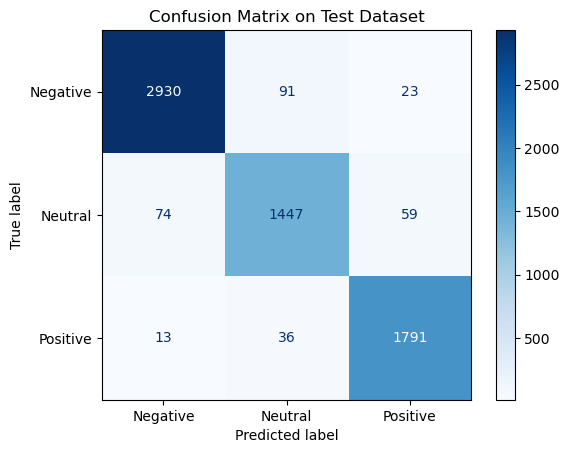


Saving detailed results to 'model_predictions.csv' ...
File saved: model_predictions.csv


In [9]:
from transformers import pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# 1️ Načtení modelu a tokenizeru
model_path = "./roberta-sentiment-empathetic"
tokenizer_name = "roberta-base"

print("Loading model and tokenizer...")
sentiment_pipe = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=tokenizer_name,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

# 2️ Test inference – kontrola na několika vlastních větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting."
]

print("\n=== SAMPLE INFERENCE ===")
for text in sample_texts:
    preds = sentiment_pipe(text)[0]
    preds_sorted = sorted(preds, key=lambda x: x['score'], reverse=True)
    print(f"\nText: {text}")
    for p in preds_sorted:
        print(f"  {p['label']}: {p['score']:.4f}")

# 3️ Vyhodnocení na testovacím datasetu (pokud máš test_ds2 z paměti)
try:
    print("\n=== EVALUATION ON TEST DATASET ===")
    predictions = trainer2.predict(test_ds2)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=-1)

    # Metriky
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # 4️ Matice záměn
    labels = ["Negative", "Neutral", "Positive"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix on Test Dataset")
    plt.show()

    # 5️ Uložení výsledků do CSV
    print("\nSaving detailed results to 'model_predictions.csv' ...")
    df_results = pd.DataFrame({
        "text": test_ds2["text"],
        "true_label": [labels[i] for i in y_true],
        "pred_label": [labels[i] for i in y_pred]
    })
    df_results.to_csv("model_predictions.csv", index=False)
    print("File saved: model_predictions.csv")

except NameError:
    print("\n⚠️ Variable 'trainer2' or 'test_ds2' not found. Please make sure to load your dataset and trainer first.")


In [4]:
from transformers import RobertaForSequenceClassification

# 1️ Načti model
model_path = "./roberta-sentiment-empathetic"
model = RobertaForSequenceClassification.from_pretrained(model_path)

# 2️ Nastav správné názvy tříd
model.config.id2label = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}
model.config.label2id = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

# 3️ Ulož novou konfiguraci
model.save_pretrained(model_path)

print("✅ Mapping labelů byl aktualizován a uložen do config.json")


✅ Mapping labelů byl aktualizován a uložen do config.json


In [10]:
from transformers import pipeline
import torch

sentiment_pipe = pipeline(
    "text-classification",
    model=model_path,
    tokenizer="roberta-base",
    top_k=None,  # moderní varianta místo return_all_scores=True
    device=0 if torch.cuda.is_available() else -1
)

sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting."
]

for text in sample_texts:
    preds = sentiment_pipe(text)
    print(f"\n{text}")
    for p in preds[0]:
        print(f"  {p['label']}: {p['score']:.4f}")


Device set to use cuda:0



I am so happy today! Everything went perfectly.
  LABEL_2: 0.9995
  LABEL_1: 0.0003
  LABEL_0: 0.0002

I feel so sad and disappointed.
  LABEL_0: 0.9986
  LABEL_1: 0.0012
  LABEL_2: 0.0002

It's just an ordinary day, nothing special happened.
  LABEL_2: 0.9884
  LABEL_0: 0.0102
  LABEL_1: 0.0014

I'm frustrated and angry about this situation.
  LABEL_0: 0.9976
  LABEL_1: 0.0023
  LABEL_2: 0.0002

I'm nervous about tomorrow's meeting.
  LABEL_0: 0.9965
  LABEL_1: 0.0033
  LABEL_2: 0.0002


In [11]:
# diagnostika_config_a_distribution.py
import json
from collections import Counter
from pathlib import Path
import numpy as np

# 1) Zkontroluj model config
model_path = "./roberta-sentiment-empathetic"
cfg_path = Path(model_path) / "config.json"
print("Config exists:", cfg_path.exists())
if cfg_path.exists():
    with open(cfg_path, "r", encoding="utf-8") as f:
        config = json.load(f)
    print("Model id2label:", config.get("id2label"))
    print("Model label2id:", config.get("label2id"))

# 2) Zjisti rozložení labelů v datasetu (pokud máš train_ds2, valid_ds2, test_ds2)
try:
    print("\nTrain label counts:", Counter(train_ds2["label"]))
    print("Valid label counts:", Counter(valid_ds2["label"]))
    print("Test  label counts:", Counter(test_ds2["label"]))
except NameError:
    print("Datasety train_ds2/valid_ds2/test_ds2 nejsou v paměti. Načti je před spuštěním.")


Config exists: True
Model id2label: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2'}
Model label2id: {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}

Train label counts: Counter({0: 24355, 2: 14713, 1: 12640})
Valid label counts: Counter({0: 3045, 2: 1839, 1: 1580})
Test  label counts: Counter({0: 3044, 2: 1840, 1: 1580})


In [12]:
print("class_weights2:", class_weights2)


class_weights2: tensor([0.7077, 1.3636, 1.1715])


In [ ]:
from transformers import pipeline, RobertaTokenizer, RobertaForSequenceClassification
import torch

# Načtení modelu a tokenizeru
model_path = "./roberta-sentiment-empathetic"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = 0 if torch.cuda.is_available() else -1

sentiment_pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,   # pro zobrazení všech tří tříd
    device=device
)

# Test na několika větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting."
]

print("\n=== SAMPLE INFERENCE ===\n")
for text in sample_texts:
    scores = sentiment_pipe(text)[0]
    print(f"Text: {text}")
    for score in scores:
        label = score['label']
        value = score['score']
        # přejmenování labelů podle ClassLabel
        if label == "LABEL_0":
            label_name = "Negative"
        elif label == "LABEL_1":
            label_name = "Neutral"
        else:
            label_name = "Positive"
        print(f"  {label_name}: {value:.4f}")
    print()


=== EVALUATION ON TEST DATASET ===
Accuracy : 0.9542
Precision: 0.9542
Recall   : 0.9542
F1 Score : 0.9542


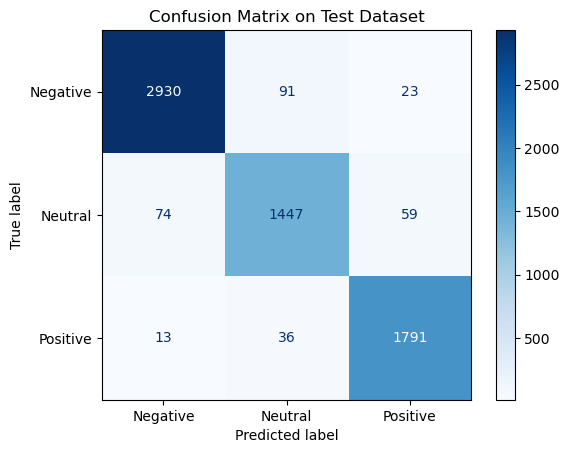

In [14]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1️ Načtení modelu a tokenizeru
model_path = "./roberta-sentiment-empathetic"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 2️ Příprava testovacího DataLoaderu
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(x["input_ids"]) for x in batch])
    attention_mask = torch.stack([torch.tensor(x["attention_mask"]) for x in batch])
    labels = torch.tensor([x["label"] for x in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

test_loader = DataLoader(test_ds2, batch_size=16, shuffle=False, collate_fn=collate_fn)

# 3️ Inference na testovacích datech
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 4️ Výpočet metrik
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print("=== EVALUATION ON TEST DATASET ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# 5️ Confusion matrix
labels = ["Negative", "Neutral", "Positive"]
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Test Dataset")
plt.show()


In [15]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
import numpy as np

# 1️ Načtení modelu a tokenizeru
model_path = "./roberta-sentiment-empathetic"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 2️ Vybereme několik testovacích vzorků
sample_ds = test_ds2.select(range(min(10, len(test_ds2))))  # prvních 10 vzorků
sample_texts = [x["text"] for x in sample_ds]
true_labels = [x["label"] for x in sample_ds]

# 3️ Inference
print("=== QUICK SAMPLE INFERENCE ===\n")
for text, true_label in zip(sample_texts, true_labels):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=-1).item()
    
    # Převod labelů na názvy
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    print(f"Text: {text}")
    print(f"  True label : {label_map[true_label]}")
    print(f"  Pred label : {label_map[pred_label]}\n")


=== QUICK SAMPLE INFERENCE ===

Text: My friends dog ran away. we looked for him all day but we couldnt find him. I was pretty upset about it <NAME> :<NAME> was really nice of you. Did you find it? Agent :
  True label : Negative
  Pred label : Negative

Text: My flight has been delayed 7 hours due to weather, I'm mad. Customer :<NAME> to weather. <NAME> did I pick the wrong day to travel. Agent :
  True label : Negative
  Pred label : Negative

Text: I wanted to do something to show my <NAME> some love so I made her a dinner of all of her favorites. I made extras for the freezer so she would be able to enjoy them again. Customer :aww that's so sweet of you to do, did she enjoy that? Agent :
  True label : Neutral
  Pred label : Neutral

Text: I was looking at some of the old photos I have of my grandpa. He passed away, so I've been reminiscing over him. Customer :I'm so sorry. I know that must be very difficult for you. It's nice that you have pictures to look at and remember old time

In [1]:
from transformers import pipeline, RobertaTokenizer, RobertaForSequenceClassification
import torch

# Načtení modelu a tokenizeru
model_path = "./roberta-sentiment-empathetic"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = 0 if torch.cuda.is_available() else -1

sentiment_pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,   # pro zobrazení všech tří tříd
    device=device
)

# Test na několika větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting."
]

print("\n=== SAMPLE INFERENCE ===\n")
for text in sample_texts:
    scores = sentiment_pipe(text)[0]
    print(f"Text: {text}")
    for score in scores:
        label = score['label']
        value = score['score']
        # přejmenování labelů podle ClassLabel
        if label == "LABEL_0":
            label_name = "Negative"
        elif label == "LABEL_1":
            label_name = "Neutral"
        else:
            label_name = "Positive"
        print(f"  {label_name}: {value:.4f}")
    print()


Device set to use cuda:0
/opt/conda/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



=== SAMPLE INFERENCE ===

Text: I am so happy today! Everything went perfectly.
  Negative: 0.0002
  Neutral: 0.0003
  Positive: 0.9995

Text: I feel so sad and disappointed.
  Negative: 0.9986
  Neutral: 0.0012
  Positive: 0.0002

Text: It's just an ordinary day, nothing special happened.
  Negative: 0.0102
  Neutral: 0.0014
  Positive: 0.9884

Text: I'm frustrated and angry about this situation.
  Negative: 0.9976
  Neutral: 0.0023
  Positive: 0.0002

Text: I'm nervous about tomorrow's meeting.
  Negative: 0.9965
  Neutral: 0.0033
  Positive: 0.0002

